This script was used to generate exploitation graph and to let play CFR algorithms against each other.

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert( 0, '..' )

In [2]:
import numpy as np
import copy
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool

from src.game import IState, ModifiedRPSState, KuhnPokerState, ECardState, LeducPokerState
from src.cfr import Exploitability, CFRTrainer, CFRPlusTrainer, LinearCFRTrainer, \
                    DiscountedCFRTrainer, ExternalMCCFRTrainer, OutcomeMCCFRTrainer, CFRUtility

## Exploitability

In [3]:
# Compute strategies for all methods, save timestamps each minutes for first 10 minutes,
# then each 10 minutes, train for 60 minutes total

def train_method( trainer_class ):
    cfr_trainer = trainer_class( LeducPokerState.initial_state() )
    cfr_timestamps = []
    
    for i in range( 10 ):
        start = time.time()

        while ( time.time() - start ) < 60:
            cfr_trainer.train( 100 )
        cfr_timestamps.append( ( copy.deepcopy( cfr_trainer.get_strategy_sum() ), cfr_trainer.total_iterations ) )
        print( f"{trainer_class}: finished {i+1}/10 minutes" )
    
    for i in range( 5 ):
        start = time.time()

        while ( time.time() - start ) < 600:
            cfr_trainer.train( 100 )
        cfr_timestamps.append( ( copy.deepcopy( cfr_trainer.get_strategy_sum() ), cfr_trainer.total_iterations ) )
        print( f"{trainer_class}: finished {i+1}/5 10minutes" )
    return cfr_timestamps

trainer_classes = [ CFRTrainer, CFRPlusTrainer, LinearCFRTrainer, DiscountedCFRTrainer, ExternalMCCFRTrainer, OutcomeMCCFRTrainer]
with Pool( 6 ) as p:
    trainer_timestamps = p.map( train_method, trainer_classes )

<class 'src.cfr.OutcomeMCCFRTrainer'>: finished 1/10 minutes
<class 'src.cfr.ExternalMCCFRTrainer'>: finished 1/10 minutes
<class 'src.cfr.CFRTrainer'>: finished 1/10 minutes
<class 'src.cfr.CFRPlusTrainer'>: finished 1/10 minutes
<class 'src.cfr.LinearCFRTrainer'>: finished 1/10 minutes
<class 'src.cfr.DiscountedCFRTrainer'>: finished 1/10 minutes
<class 'src.cfr.OutcomeMCCFRTrainer'>: finished 2/10 minutes
<class 'src.cfr.ExternalMCCFRTrainer'>: finished 2/10 minutes
<class 'src.cfr.CFRTrainer'>: finished 2/10 minutes
<class 'src.cfr.LinearCFRTrainer'>: finished 2/10 minutes
<class 'src.cfr.CFRPlusTrainer'>: finished 2/10 minutes
<class 'src.cfr.DiscountedCFRTrainer'>: finished 2/10 minutes
<class 'src.cfr.OutcomeMCCFRTrainer'>: finished 3/10 minutes
<class 'src.cfr.ExternalMCCFRTrainer'>: finished 3/10 minutes
<class 'src.cfr.CFRTrainer'>: finished 3/10 minutes
<class 'src.cfr.LinearCFRTrainer'>: finished 3/10 minutes
<class 'src.cfr.CFRPlusTrainer'>: finished 3/10 minutes
<class 's

In [4]:
# Number of finished iterations at each timestamp for CFRTrainer
[ x[1] for x in trainer_timestamps[0] ]

[300,
 600,
 900,
 1200,
 1500,
 1800,
 2100,
 2400,
 2700,
 3000,
 5600,
 8100,
 10700,
 13200,
 15800]

In [5]:
# Computes exploitability for timestamps for all trainers

def compute_timestamp_exploitability( cfr_timestamps ):
    exploit_list = []
    i = 0
    for strategy_sum, _ in cfr_timestamps:
        strategy = CFRUtility.regret_matching( strategy_sum )
        exploitability = Exploitability( LeducPokerState.initial_state(), strategy )
        exploitability.compute()
        exploit_list.append( exploitability.get_ev() )
        i += 1
    return exploit_list

with Pool( 6 ) as p:
    exploit_lists = p.map( compute_timestamp_exploitability, trainer_timestamps )

Text(0.5, 0, 'Training time (minutes)')

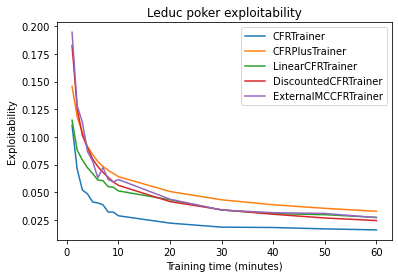

In [6]:
# Plot exploitabilities of CFR algorithms.

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60 ]
exploitabilities = [ [ x["exploitability"] for x in l ] for l in exploit_lists ]

for i in range( len( exploitabilities[:5] ) ):
    plt.plot( x, exploitabilities[i], label=trainer_classes[i].__name__ )
plt.legend()
plt.title( "Leduc poker exploitability" )
plt.ylabel( "Exploitability" )
plt.xlabel( "Training time (minutes)" )

Text(0.5, 0, 'Training time (minutes)')

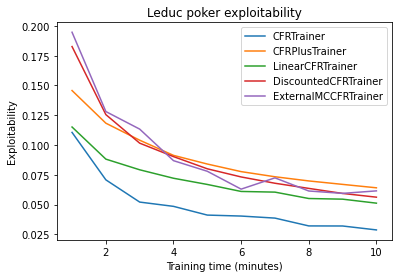

In [7]:
# Plot exploitabilities of CFR algorithms.

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60 ]
exploitabilities = [ [ x["exploitability"] for x in l ] for l in exploit_lists ]

for i in range( len( exploitabilities[:5] ) ):
    plt.plot( x[:10], exploitabilities[i][:10], label=trainer_classes[i].__name__ )
plt.legend()
plt.title( "Leduc poker exploitability" )
plt.ylabel( "Exploitability" )
plt.xlabel( "Training time (minutes)" )

Text(0.5, 0, 'Training time (minutes)')

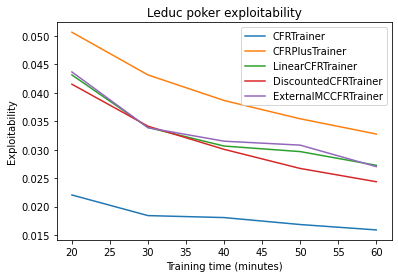

In [8]:
# Plot exploitabilities of CFR algorithms.

x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60 ]
exploitabilities = [ [ x["exploitability"] for x in l ] for l in exploit_lists ]

for i in range( len( exploitabilities[:5] ) ):
    plt.plot( x[10:], exploitabilities[i][10:], label=trainer_classes[i].__name__ )
plt.legend()
plt.title( "Leduc poker exploitability" )
plt.ylabel( "Exploitability" )
plt.xlabel( "Training time (minutes)" )

## 1v1 plays

In [9]:
def simulate_games( strategy1, strategy2, iters=100000 ):
    evs = []
    for i in range( iters // 2 ):
        evs.append( CFRUtility.simulate_game( LeducPokerState.initial_state(), [ strategy1, strategy2 ] ) )
    for i in range( iters // 2 ):
        evs.append( -CFRUtility.simulate_game( LeducPokerState.initial_state(), [ strategy2, strategy1 ] ) )
    return evs

def play_strategies( pair ):
    i, j = pair
    strategy1 = strategies[i]
    strategy2 = strategies[j]
    iters=250000
    evs = simulate_games( strategy1, strategy2, iters )
    avg = np.mean( evs )
    sd = np.var( evs )**0.5
    t = avg / sd * iters**0.5

    key = trainer_classes[i].__name__ + ":" + trainer_classes[j].__name__
#     results.append( ( trainer_classes[i].__name__, trainer_classes[j].__name__, avg, t ) )
#     results.append( ( trainer_classes[j].__name__, trainer_classes[i].__name__, -avg, t ) )
    res = []
    res.append( ( trainer_classes[i].__name__, trainer_classes[j].__name__, avg, t ) )
    res.append( ( trainer_classes[j].__name__, trainer_classes[i].__name__, -avg, t ) )
    print( i, j, "finished" )
    return res

strategy_sums = [ x[-1][0] for x in trainer_timestamps ]
strategies = [ CFRUtility.regret_matching( x ) for x in strategy_sums ]
strategy_indices = []

for i in range( len( strategies ) ):
    for j in range( i+1, len( strategies ) ):
        strategy_indices.append( ( i, j ) )

with Pool( 24 ) as p:
    results = p.map( play_strategies, strategy_indices )
    results = [ item for sublist in results for item in sublist ]

0 3 finished
0 2 finished
2 4 finished
3 4 finished
0 1 finished
2 3 finished
0 4 finished
1 4 finished
1 3 finished
1 2 finished
3 5 finished
2 5 finished
0 5 finished
4 5 finished
1 5 finished


In [10]:
results

[('CFRTrainer', 'CFRPlusTrainer', 0.006756, 0.9654657961561139),
 ('CFRPlusTrainer', 'CFRTrainer', -0.006756, 0.9654657961561139),
 ('CFRTrainer', 'LinearCFRTrainer', 0.009044, 1.2940991887807352),
 ('LinearCFRTrainer', 'CFRTrainer', -0.009044, 1.2940991887807352),
 ('CFRTrainer', 'DiscountedCFRTrainer', 0.009148, 1.3069484556490174),
 ('DiscountedCFRTrainer', 'CFRTrainer', -0.009148, 1.3069484556490174),
 ('CFRTrainer', 'ExternalMCCFRTrainer', 0.014912, 2.130969679857157),
 ('ExternalMCCFRTrainer', 'CFRTrainer', -0.014912, 2.130969679857157),
 ('CFRTrainer', 'OutcomeMCCFRTrainer', 0.571968, 52.84484847655558),
 ('OutcomeMCCFRTrainer', 'CFRTrainer', -0.571968, 52.84484847655558),
 ('CFRPlusTrainer', 'LinearCFRTrainer', 0.00714, 1.0216198209841438),
 ('LinearCFRTrainer', 'CFRPlusTrainer', -0.00714, 1.0216198209841438),
 ('CFRPlusTrainer', 'DiscountedCFRTrainer', 0.008484, 1.211853398262418),
 ('DiscountedCFRTrainer', 'CFRPlusTrainer', -0.008484, 1.211853398262418),
 ('CFRPlusTrainer', '

In [11]:
# statistically significant results
u_5perc = 1.96
[ result for result in results if abs( result[3] ) > u_5perc ]

[('CFRTrainer', 'ExternalMCCFRTrainer', 0.014912, 2.130969679857157),
 ('ExternalMCCFRTrainer', 'CFRTrainer', -0.014912, 2.130969679857157),
 ('CFRTrainer', 'OutcomeMCCFRTrainer', 0.571968, 52.84484847655558),
 ('OutcomeMCCFRTrainer', 'CFRTrainer', -0.571968, 52.84484847655558),
 ('CFRPlusTrainer', 'ExternalMCCFRTrainer', 0.016092, 2.2990124442784485),
 ('ExternalMCCFRTrainer', 'CFRPlusTrainer', -0.016092, 2.2990124442784485),
 ('CFRPlusTrainer', 'OutcomeMCCFRTrainer', 0.579416, 53.572115361824146),
 ('OutcomeMCCFRTrainer', 'CFRPlusTrainer', -0.579416, 53.572115361824146),
 ('LinearCFRTrainer', 'ExternalMCCFRTrainer', 0.014584, 2.085635293322969),
 ('ExternalMCCFRTrainer', 'LinearCFRTrainer', -0.014584, 2.085635293322969),
 ('LinearCFRTrainer', 'OutcomeMCCFRTrainer', 0.542024, 50.18231888964079),
 ('OutcomeMCCFRTrainer', 'LinearCFRTrainer', -0.542024, 50.18231888964079),
 ('DiscountedCFRTrainer',
  'ExternalMCCFRTrainer',
  0.015872,
  2.2669086226109414),
 ('ExternalMCCFRTrainer',
  '

## Evaluation of simple strategies

In [12]:
# Exploitability of random strategy and its performance against CFRTrainer

random_strategy = CFRUtility.regret_matching( {} )

exploitability = Exploitability( LeducPokerState.initial_state(), random_strategy )
exploitability.compute()
print( "Random strategy exploitability =", exploitability.get_ev()["exploitability"] )

ev = CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ random_strategy, strategies[0] ] ) - CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ strategies[0], random_strategy ] )
print( "Random strategy vs. Vanilla CFR EV =", ev )

Random strategy exploitability = 4.747222222222222
Random strategy vs. Vanilla CFR EV = -1.450901253481892


In [13]:
# Exploitability of always call strategy and its performance againts CFRTrainer

def always_call( infoset ):
    available_actions = infoset[1]
    probs = np.zeros( len( available_actions ) )
    for i, action in enumerate( available_actions ):
        if action == "c":
            probs[i] = 1
    return probs

exploitability = Exploitability( LeducPokerState.initial_state(), always_call )
exploitability.compute()
print( "Always call exploitability =", exploitability.get_ev()["exploitability"] )

ev = CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ always_call, strategies[0] ] ) - CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ strategies[0], always_call ] )
print( "Always call vs. Vanilla CFR EV =", ev )

Always call exploitability = 2.9333333333333336
Always call vs. Vanilla CFR EV = -1.366066750334511


In [14]:
# Exploitability of check-fold strategy and its performance againts CFRTrainer

def check_fold( infoset ):
    available_actions = infoset[1]
    probs = np.zeros( len( available_actions ) )
    if "f" in available_actions:
        probs[0] = 1
        return probs
    for i, action in enumerate( available_actions ):
        if action == "c":
            probs[i] = 1
    return probs

exploitability = Exploitability( LeducPokerState.initial_state(), check_fold )
exploitability.compute()
print( "check-fold exploitability =", exploitability.get_ev()["exploitability"] )

ev = CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ check_fold, strategies[0] ] ) - CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ strategies[0], check_fold ] )
print( "check-fold vs. Vanilla CFR EV =", ev )

check-fold exploitability = 1.9999999999999998
check-fold vs. Vanilla CFR EV = -1.1393517337037575


In [15]:
# Performance of check-fold against OutcomeMCCFR

def check_fold( infoset ):
    available_actions = infoset[1]
    probs = np.zeros( len( available_actions ) )
    if "f" in available_actions:
        probs[0] = 1
        return probs
    for i, action in enumerate( available_actions ):
        if action == "c":
            probs[i] = 1
    return probs

ev = CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ check_fold, strategies[-1] ] ) - CFRUtility.evaluate_strategies( LeducPokerState.initial_state(), [ strategies[-1], check_fold ] )
print( "check-fold vs. OutcomeMCCFR EV =", ev )

check-fold vs. OutcomeMCCFR EV = -0.8155824916308916


In [16]:
def bk_qr_jcf( infoset ):
    """
    Bet King, Queen random, Jack check_fold
    """
    available_actions = infoset[1]
    card = infoset[0][0]
    if card == "K":
        probs = np.zeros( len( available_actions ) )
        probs[-1] = 1
        return probs
    if card == "Q":
        probs = np.ones( len( available_actions ) )
        return probs / np.sum( probs )
    if card == "J":
        probs = np.zeros( len( available_actions ) )
        if "f" in available_actions:
            probs[0] = 1
            return probs
        for i, action in enumerate( available_actions ):
            if action == "c":
                probs[i] = 1
        return probs
    print( "Infoset: ", infoset )
    raise Exception( "This shouldn't be reached with correct infoset" )
    
exploitability = Exploitability( LeducPokerState.initial_state(), bk_qr_jcf )
exploitability.compute()
print( "bk_qr_jcf exploitability =", exploitability.get_ev()["exploitability"] )

bk_qr_jcf exploitability = 2.081944444444444
